In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pillow_heif

In [2]:
frames_dir = "frames"
start_index, end_index = 9272, 9289
image_ext = ".HEIC"
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

In [3]:
def image_loading(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in ['.heic', '.heif']:
        heif_file = pillow_heif.read_heif(path)
        img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw")
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    else:
        img_cv = cv2.imread(path)
    return img_cv


In [4]:
def feature_detector(method='SIFT', nfeatures=4000):
    method = method.upper()
    if method == 'SIFT':
        detector = cv2.SIFT_create(
            nfeatures=nfeatures,
            contrastThreshold=0.05,
            edgeThreshold=10,
            sigma=1.6
        )
        return detector, 'SIFT'
    else:
        detector = cv2.ORB_create(nfeatures=nfeatures)
        return detector, 'ORB'


In [5]:
def detect_features(detector, image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kp, desc = detector.detectAndCompute(gray, None)
    return kp, desc

In [6]:
def keypoints_matching_filtering(descriptor_1, descriptor_2, method_name='SIFT', ratio=0.7):
    if descriptor_1 is None or descriptor_2 is None:
        return []

    if method_name == 'SIFT':
        if descriptor_1.dtype != np.float32:
            descriptor_1 = descriptor_1.astype(np.float32)
            descriptor_2 = descriptor_2.astype(np.float32)
        index_parameters = dict(algorithm=1, trees=5)
        search_parameters = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_parameters, search_parameters)
        knn_matches = matcher.knnMatch(descriptor_1, descriptor_2, k=2)

    good = []
    for m_n in knn_matches:
        if len(m_n) < 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

In [7]:
def keypoints_visualize_Nsave(image_1, image_2, keypoint_1, keypoint_2, matches, label):
    matched_img = cv2.drawMatches(
        image_1, keypoint_1, image_2, keypoint_2, matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(14, 7))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Filtered Matches ({label}) - {len(matches)} good matches")
    plt.axis('off')
    plt.show()

    path_output = os.path.join(output_dir, f"matches_{label}.png")
    cv2.imwrite(path_output, matched_img)

In [8]:
detector, method_name = feature_detector('SIFT', nfeatures=4000)
match_counts = []

for i in range(start_index, end_index):
    path_1 = os.path.join(frames_dir, f"IMG_{i}{image_ext}")
    path_2 = os.path.join(frames_dir, f"IMG_{i+1}{image_ext}")

    image_1 = image_loading(path_1)
    image_2 = image_loading(path_2)
    keypoint_1, descriptor_1 = detect_features(detector, image_1)
    keypoint_2, descriptor_2 = detect_features(detector, image_2)
    matches = keypoints_matching_filtering(descriptor_1, descriptor_2, method_name=method_name, ratio=0.7)
    num_matches = len(matches)

    print(f"IMG_{i} - IMG_{i+1}: {num_matches} good matches")
    match_counts.append((i, num_matches, keypoint_1, keypoint_2, matches, image_1, image_2))

IMG_9272 - IMG_9273: 1025 good matches
IMG_9273 - IMG_9274: 916 good matches
IMG_9274 - IMG_9275: 1205 good matches
IMG_9275 - IMG_9276: 1196 good matches
IMG_9276 - IMG_9277: 1643 good matches
IMG_9277 - IMG_9278: 850 good matches
IMG_9278 - IMG_9279: 1057 good matches
IMG_9279 - IMG_9280: 838 good matches
IMG_9280 - IMG_9281: 539 good matches
IMG_9281 - IMG_9282: 127 good matches
IMG_9282 - IMG_9283: 841 good matches
IMG_9283 - IMG_9284: 1904 good matches
IMG_9284 - IMG_9285: 1634 good matches
IMG_9285 - IMG_9286: 1146 good matches
IMG_9286 - IMG_9287: 850 good matches
IMG_9287 - IMG_9288: 1113 good matches
IMG_9288 - IMG_9289: 860 good matches


In [9]:
match_counts.sort(key=lambda x: x[1], reverse=True)
print("\nTop 5 image pairs with strongest overlap:")
for index, count, *_ in match_counts[:5]:
    print(f"IMG_{index} - IMG_{index+1}: {count} matches")


Top 5 image pairs with strongest overlap:
IMG_9283 - IMG_9284: 1904 matches
IMG_9276 - IMG_9277: 1643 matches
IMG_9284 - IMG_9285: 1634 matches
IMG_9274 - IMG_9275: 1205 matches
IMG_9275 - IMG_9276: 1196 matches



 Visualizing top 3 match pairs


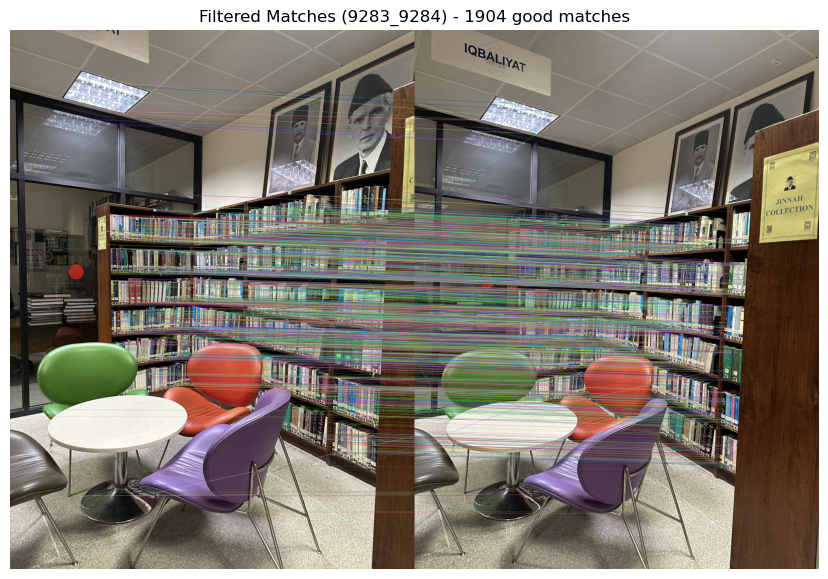

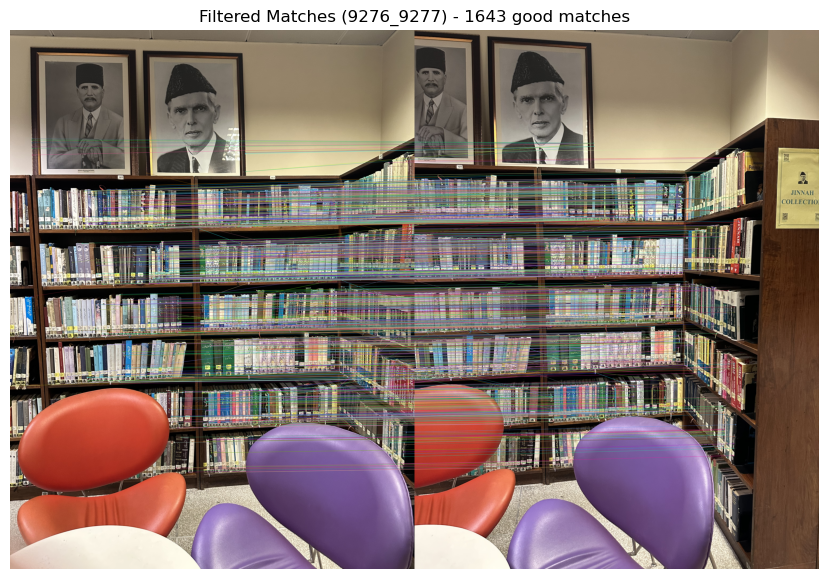

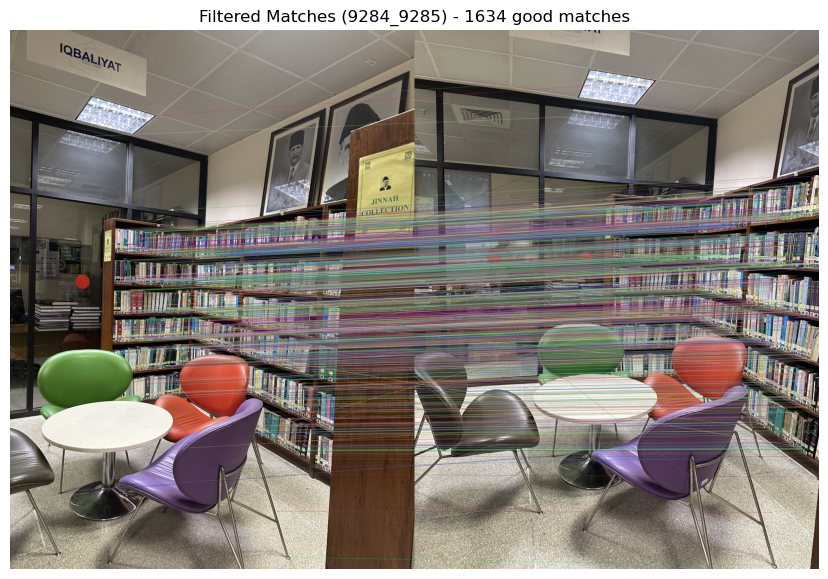

In [10]:
print("\n Visualizing top 3 match pairs")
for index, count, keypoint_1, keypoint_2, matches, image_1, image_2 in match_counts[:3]:
    label = f"{index}_{index+1}"
    keypoints_visualize_Nsave(image_1, image_2, keypoint_1, keypoint_2, matches, label)

## Week 2: Two-View Reconstruction

In [ ]:
best_index, _, kp1, kp2, matches, img1_best, img2_best = match_counts[0]

print(f"Using image pair: IMG_{best_index} and IMG_{best_index+1}")
print("Total matches:", len(matches))

pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])


Using image pair: IMG_9283 and IMG_9284
Total matches: 1904


### 2. Build Intrinsic Matrix (K)
I use the simplified intrinsic calibration as suggested in the project manual and validated by the TA:

- `fx = fy = image_width`
- `cx = w/2`
- `cy = h/2`

This approximation is sufficient for Week 2 reconstruction.


In [14]:
h, w = img1_best.shape[:2]
f = w  # simplified assumption

K = np.array([
    [f, 0, w/2],
    [0, f, h/2],
    [0, 0, 1]
])

print("Intrinsic Matrix K:\n", K)


Intrinsic Matrix K:
 [[3.024e+03 0.000e+00 1.512e+03]
 [0.000e+00 3.024e+03 2.016e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


### 3. Estimate the Essential Matrix using RANSAC
Using the matched feature points and the intrinsic matrix, I compute:

- The **Essential Matrix (E)**  
- A robust inlier mask from RANSAC  


In [ ]:
E, mask_E = cv2.findEssentialMat(
    pts1, pts2, K,
    cv2.RANSAC, prob=0.999, threshold=1.0
)

print("Estimated Essential Matrix:\n", E)
print("Inliers:", np.sum(mask_E))


Estimated Essential Matrix:
 [[ 0.01676299  0.44639758 -0.05423143]
 [-0.4203676   0.02789574 -0.56405479]
 [ 0.08286325  0.54286376  0.01717189]]
Inliers: 1497


### 4. Recover Camera Pose (R, t)
The Essential Matrix has four possible decompositions.  
`recoverPose()` automatically resolves ambiguity using the **cheirality condition** (points must lie in front of cameras).


In [16]:
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

print("Recovered Rotation R:\n", R)
print("\nRecovered Translation t:\n", t)


Recovered Rotation R:
 [[ 0.99853833 -0.03222546  0.04339036]
 [ 0.03110599  0.99917179  0.02623271]
 [-0.04419978 -0.02484467  0.99871373]]

Recovered Translation t:
 [[-0.77137171]
 [ 0.09332847]
 [ 0.62950416]]


### 5. Triangulate 3D Points
Using projection matrices:

- Camera 1: `P0 = K [I | 0]`  
- Camera 2: `P1 = K [R | t]`  

I triangulate corresponding points into a 3D point cloud.


In [ ]:
P0 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P1 = K @ np.hstack((R, t))

pts4D = cv2.triangulatePoints(P0, P1, pts1.T, pts2.T)
pts3D = (pts4D[:3] / pts4D[3]).T

print("Triangulated 3D points:", pts3D.shape)


Triangulated 3D points: (1904, 3)


In [18]:
valid_mask = np.isfinite(pts3D).all(axis=1)
pts3D = pts3D[valid_mask]

print("Valid 3D points:", pts3D.shape)


Valid 3D points: (1904, 3)


### 6. Visualize the 3D Point Cloud
I now plot the reconstructed points in:

- **3D view**  
- **2D projection (X vs Z)**  

as required by the TA.


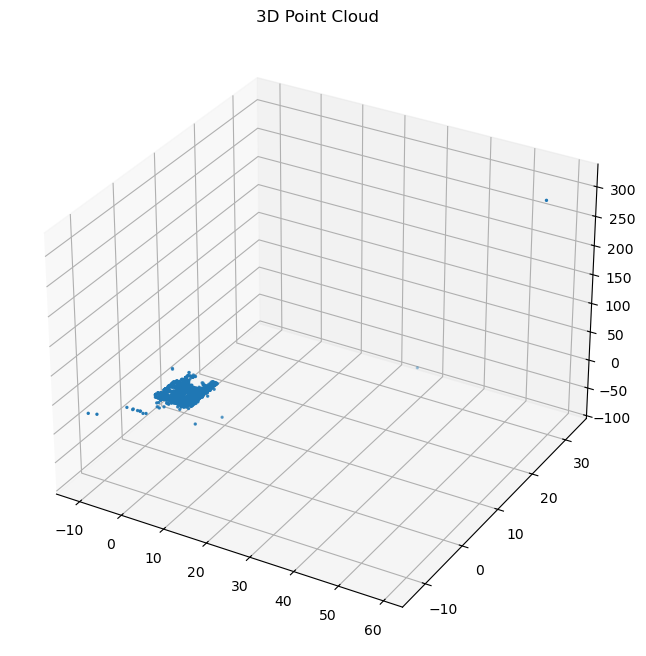

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts3D[:,0], pts3D[:,1], pts3D[:,2], s=2)
ax.set_title("3D Point Cloud")
plt.show()


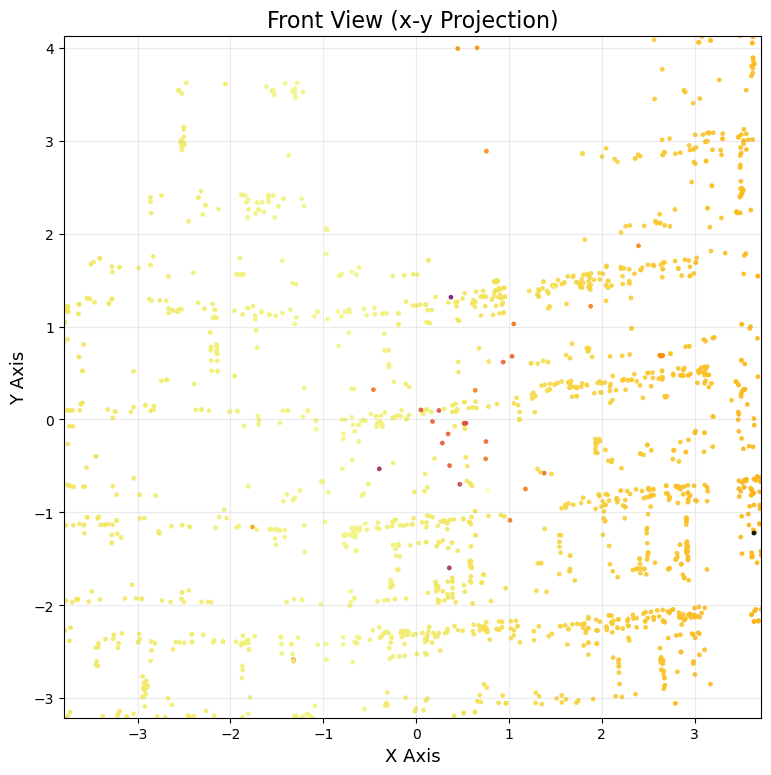

In [40]:
x = pts3D[:, 0]
y = pts3D[:, 1]

x_min, x_max = np.percentile(x, [2, 98])
y_min, y_max = np.percentile(y, [2, 98])

mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
pts_filtered = pts3D[mask]

x_f = pts_filtered[:, 0]
y_f = pts_filtered[:, 1]
z_f = pts_filtered[:, 2]

plt.figure(figsize=(9, 9))
plt.scatter(
    x_f, y_f,
    s=6,
    c=z_f,
    cmap='inferno',
    alpha=0.85
)

plt.title("Front View (x-y Projection)", fontsize=16)
plt.xlabel("X Axis", fontsize=13)
plt.ylabel("Y Axis", fontsize=13)

plt.xlim(x_f.min(), x_f.max())
plt.ylim(y_f.min(), y_f.max())

plt.gca().set_aspect('equal', 'box')

plt.grid(alpha=0.25)
plt.show()


### 7. Export the Point Cloud (PLY format)
This file will be used in Week 3 for multi-view SfM and refinement.


In [22]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts3D)

ply_path = os.path.join(output_dir, "two_view_cloud.ply")
o3d.io.write_point_cloud(ply_path, pcd)

print("Saved PLY:", ply_path)


Saved PLY: outputs/two_view_cloud.ply


### Week 2 Completed  
I completed the two-view SfM pipeline:

- Selected best pair from Week 1  
- Built intrinsic matrix  
- Estimated Essential Matrix  
- Recovered relative pose  
- Triangulated 3D points  
- Visualized 3D and 2D scatter  
- Exported `.ply` for the next stage  

This point cloud will be refined and expanded in Week 3 using PnP and bundle adjustment techniques.
